In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import yaml

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
with open('config.yaml','r') as file:
    config = yaml.safe_load(file)
#config

In [4]:
target = config['target']
target

'Outcome'

## Experiment 1

### Data handling   --main

In [5]:
data = pd.read_csv(r"data\main.csv")
print(data.shape)
data.head(2)

(279730, 32)


,Age,Gender,Cholesterol,BloodPressure,HeartRate,BMI,Smoker,Diabetes,Hypertension,FamilyHistory,...,ExerciseInducedAngina,Slope,NumberOfMajorVessels,Thalassemia,PreviousHeartAttack,StrokeHistory,Residence,EmploymentStatus,MaritalStatus,Outcome
0,49,Female,163,158,116,31.2,0,1,0,0,...,Yes,Flat,3,Fixed defect,0,1,Rural,Employed,Widowed,Heart Attack
1,69,Male,274,160,88,20.7,0,1,0,1,...,No,Downsloping,1,Fixed defect,0,0,Suburban,Unemployed,Divorced,Heart Attack


#### Train-Test split

In [6]:
df_train, df_test = train_test_split(
                        data, 
                        test_size=config[config['exp1']['data_split']]['test_size'], 
                        random_state=config[config['exp1']['data_split']]['random_state'],
                        stratify=data[target])

#### Pre-processing

##### Train

In [7]:
def feature_mapping(df:pd.DataFrame, map_dict:dict) -> pd.DataFrame:
    df.replace(map_dict, inplace=True)
    return df

In [8]:
mapping_transformer = FunctionTransformer(feature_mapping, kw_args={'map_dict':config[config['exp1']['prepro']]['cat_map']})
#mapping_transformer = FunctionTransformer(feature_mapping)

In [9]:
pre_processing = ColumnTransformer(
    transformers=[
        ('mapping', mapping_transformer, list(config[config['exp1']['prepro']]['cat_map'].keys())),
        ('cat_1Henc', OneHotEncoder(), config[config['exp1']['prepro']]['cat_cols']),
        ('num_min_max', MinMaxScaler(), config[config['exp1']['prepro']]['num_cols'])
    ]
)

In [10]:
pre_processing = Pipeline(steps=[
                    ('map', mapping_transformer),
                    ('sub_prepro', ColumnTransformer(transformers=[
                        ('num_min_max', MinMaxScaler(), config[config['exp1']['prepro']]['num_cols']),
                        ('cat_1Henc', OneHotEncoder(), config[config['exp1']['prepro']]['cat_cols'])],
                        remainder='passthrough')
                    )]
                )                        

In [11]:
train_processed = pre_processing.fit_transform(df_train)
test_processed = pre_processing.transform(df_test)

C:\Users\anand\AppData\Local\Temp\ipykernel_37772\327147022.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(map_dict, inplace=True)
C:\Users\anand\AppData\Local\Temp\ipykernel_37772\327147022.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(map_dict, inplace=True)


In [12]:
processed_cols = [i.split('__')[-1] for i in pre_processing.named_steps['sub_prepro'].get_feature_names_out()]
train_processed_df = pd.DataFrame(train_processed,columns=processed_cols)
test_processed_df = pd.DataFrame(test_processed, columns=processed_cols)

<Axes: >

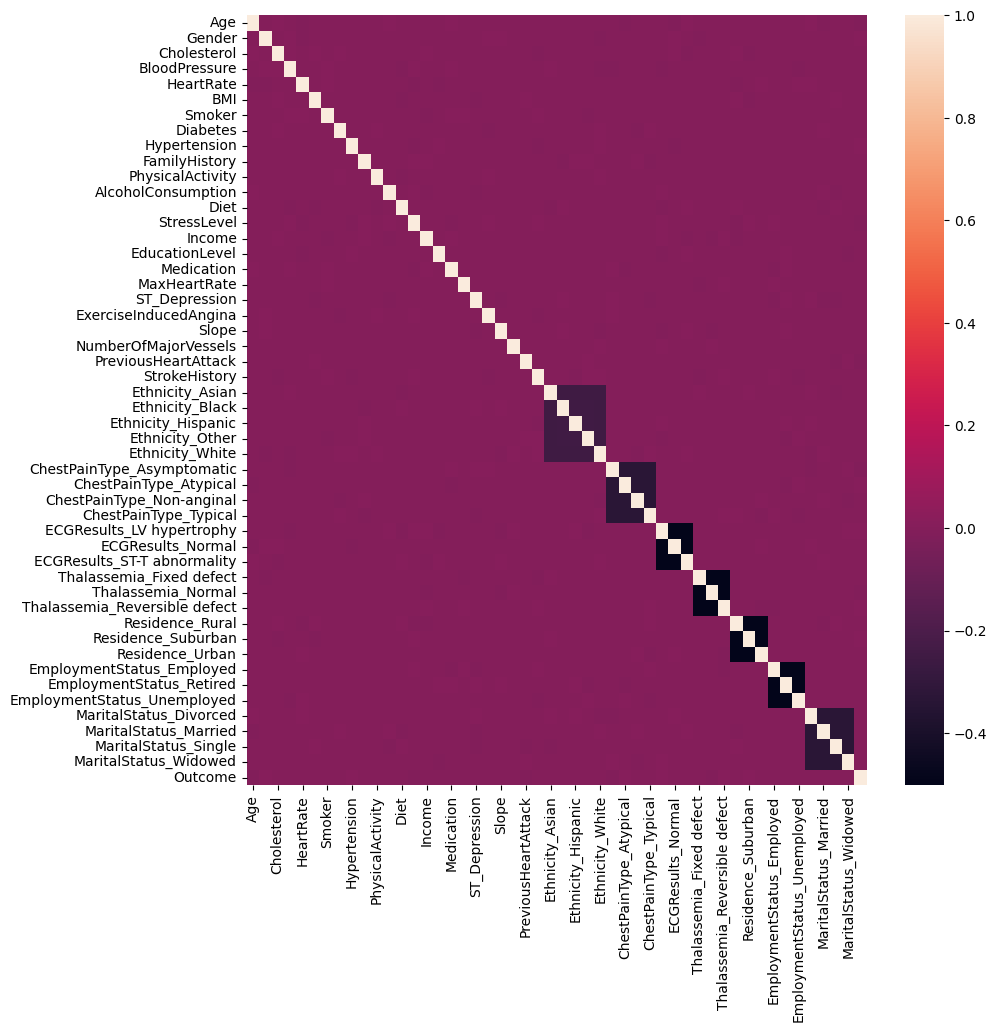

In [13]:
plt.figure(figsize=(10,10))
sns.heatmap(train_processed_df.corr(), fmt=".2f")

In [14]:
Xtrain = train_processed_df.drop(columns=[target])
Ytrain = train_processed_df[target]
print(Xtrain.shape)

(223784, 49)


In [15]:
Xtest = df_test.drop(target, axis=1)
Ytest = df_test[target]
print(Xtest.shape)

(55946, 31)


In [16]:
Xtest

,Age,Gender,Cholesterol,BloodPressure,HeartRate,BMI,Smoker,Diabetes,Hypertension,FamilyHistory,...,ST_Depression,ExerciseInducedAngina,Slope,NumberOfMajorVessels,Thalassemia,PreviousHeartAttack,StrokeHistory,Residence,EmploymentStatus,MaritalStatus
152055,79,1,251,165,117,36.3,1,1,0,1,...,2.31,1,0.0,3,Reversible defect,0,1,Urban,Unemployed,Single
54813,77,0,145,142,62,24.2,0,0,0,0,...,2.04,0,0.0,1,Fixed defect,1,1,Rural,Unemployed,Single
58066,60,1,152,165,94,39.1,1,0,1,0,...,1.98,1,1.0,3,Normal,0,0,Urban,Unemployed,Divorced
191737,61,1,160,113,101,28.9,0,0,0,0,...,0.25,0,1.0,1,Fixed defect,1,0,Suburban,Retired,Single
43662,48,0,113,147,114,28.4,0,0,1,0,...,3.35,0,0.0,3,Reversible defect,1,1,Rural,Retired,Widowed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216129,73,0,201,100,62,20.6,0,0,1,1,...,3.94,0,0.0,1,Normal,1,1,Suburban,Unemployed,Divorced
265082,79,0,275,143,104,32.5,1,0,1,1,...,1.00,0,1.0,3,Fixed defect,1,0,Rural,Unemployed,Widowed
29492,30,0,286,174,102,20.7,1,0,0,0,...,1.54,1,0.0,2,Normal,0,1,Rural,Employed,Widowed
135749,60,1,171,111,65,35.9,0,0,1,0,...,0.65,1,1.0,2,Fixed defect,1,0,Urban,Employed,Single


In [17]:
from sklearn import metrics
from sklearn.model_selection import KFold

from hyperopt import hp,fmin,tpe,Trials,STATUS_OK
import random
from functools import partial

from sklearn.ensemble import RandomForestClassifier

In [18]:
hyp = config['exp'][config['exp1']['model']]['hyperparameters']
hyp

{'n_estimators': [5, 500, 15],
 'criteria': ['gini', 'entropy', 'log_loss'],
 'max_depth': [1, 125, 10],
 'min_samples_split': [2, 100, 15],
 'max_features': [5, 250, 15]}

In [19]:
rf_params = {
'n_estimators': hp.quniform('n_estimators_label',hyp['n_estimators'][0],hyp['n_estimators'][1],hyp['n_estimators'][2]),
'criterion' : hp.choice('criterion_label',hyp['criteria']),
'max_depth' : hp.quniform('max_depth_label',hyp['max_depth'][0],hyp['max_depth'][1],hyp['max_depth'][2]),
'min_samples_split' : hp.quniform('min_samples_split_label',hyp['min_samples_split'][0],hyp['min_samples_split'][1],hyp['min_samples_split'][2]),
'max_features' : hp.quniform('max_features',hyp['max_features'][0],hyp['max_features'][1],hyp['max_features'][2])
} 

def rf_params_processing(params:dict,stage:str)->dict:
    if stage=='pre':
        lparams=dict()
        lparams['n_estimators'] = int(params['n_estimators'])
        lparams['criterion'] = params['criterion']
        lparams['max_depth'] = int(params['max_depth'])
        lparams['min_samples_split'] = int(params['min_samples_split'])
        lparams['max_features'] = int(params['max_features'])
    if stage=='post':
        lparams=dict()
        lparams['n_estimators'] = int(params['n_estimators_label'])
        lparams['criterion'] = ['gini', 'entropy', 'log_loss'][params['criterion_label']]
        lparams['max_depth'] = int(params['max_depth_label'])
        lparams['min_samples_split'] = int(params['min_samples_split_label'])
        lparams['max_features'] = int(params['max_features_label'])
    return lparams

def rf_model(params:dict, X:pd.DataFrame,Y:pd.DataFrame):
    clf = RandomForestClassifier(**params,n_jobs=-1)
    clf.fit(X, Y)
    return clf

In [20]:
def obj_func(params,space_processing,model, X:pd.DataFrame,Y:pd.DataFrame)->dict:
    clf = model(space_processing(params,'pre'), X,Y)
    Y_pred = clf.predict(X)
    acc = metrics.accuracy_score(Y, Y_pred)
    return {"loss": -acc, "status": STATUS_OK}

def nested_cv(Xtrain:pd.DataFrame, Ytrain:pd.DataFrame, space, space_processing, model, obj_func):
    skf = KFold(n_splits = 5, shuffle=True, random_state=42)
    params_exp = []
    train_score = []
    test_score =  []
    score_diff = []
    for skf_train, skf_test in skf.split(Xtrain, Ytrain):
        x_train_fold, x_test_fold = Xtrain.iloc[skf_train], Xtrain.iloc[skf_test]
        y_train_fold, y_test_fold = Ytrain.iloc[skf_train], Ytrain.iloc[skf_test]

        obj_func_wrapped = partial(obj_func,space_processing=space_processing,model=model, X=x_train_fold, Y=y_train_fold)

        trials = Trials()
        best = fmin(obj_func_wrapped, space=space, algo=tpe.suggest, max_evals=15, trials=trials)
        best_params = space_processing(best,'post')

        print(best_params)

        train_acc = metrics.accuracy_score(y_train_fold, model(best_params, x_train_fold, y_train_fold).predict(x_train_fold))
        test_acc = metrics.accuracy_score(y_test_fold, model(best_params, x_train_fold, y_train_fold).predict(x_test_fold))

        print('Train:',train_acc)
        print('Test:',test_acc)

        params_exp.append(best_params)
        train_score.append(train_acc)
        test_score.append(test_acc)
        score_diff.append(train_acc-test_acc)
    
    df = pd.DataFrame({'params':params_exp,'train_score':train_score, 'test_score':test_score, 'score_diff':score_diff})
    df_fil_sort = df.sort_values(['test_score','score_diff'], ascending=False).reset_index(drop=True)
    #final_params = df_fil_sort.iloc[0,0]

    return df_fil_sort

In [ ]:
df_fil_sort = nested_cv(Xtrain, Ytrain, rf_params, rf_params_processing, rf_model, obj_func)

 20%|██        | 3/15 [05:57<22:15, 111.30s/trial, best loss: -0.9995196255313444]

In [ ]:
df_fil_sort

,params,train_score,test_score,score_diff


In [ ]:
+

# Rough

## Logistic_regression1

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
LR = LogisticRegression()
LR.fit(Xtrain, Ytrain)

LogisticRegression()

In [ ]:
LR.score(Xtrain, Ytrain)

0.5068816358631537

In [ ]:
metrics.accuracy_score(Ytrain, LR.predict(Xtrain))

0.5068816358631537

In [ ]:
Nested Cross Validation

In [ ]:
skf = KFold(n_splits = 5, shuffle=True, random_state=42)

In [ ]:
for skf_train, skf_test in skf.split(Xtrain, Ytrain):
    print(skf_train.shape, skf_test.shape)
    

(179027,) (44757,)
(179027,) (44757,)
(179027,) (44757,)
(179027,) (44757,)
(179028,) (44756,)


{'n_estimators': 100,
 'max_depth': 5,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'random_state': 42}

In [ ]:
params_rf = {
'n_estimators': hp.quniform('n_estimators_label',5,100,5),
'criterion' : hp.choice('criterion_label',['gini', 'entropy', 'log_loss']),
'max_depth' : hp.quniform('max_depth_label',1,25,2),
'min_samples_split' : hp.quniform('min_samples_split_label',2,10,1),
'max_features' : hp.quniform('max_features_label',5,50,5)
} 

In [ ]:
def rf_params_processing(params:dict,stage:str)->dict:
    if stage=='pre':
        lparams=dict()
        lparams['n_estimators'] = int(params['n_estimators'])
        lparams['criterion'] = params['criterion']
        lparams['max_depth'] = int(params['max_depth'])
        lparams['min_samples_split'] = int(params['min_samples_split'])
        lparams['max_features'] = int(params['max_features'])
    if stage=='post':
        lparams=dict()
        lparams['n_estimators_label'] = int(params['n_estimators_label'])
        lparams['criterion_label'] = params['criterion_label']
        lparams['max_depth_label'] = int(params['max_depth_label'])
        lparams['min_samples_split_label'] = int(params['min_samples_split_label'])
        lparams['max_features_label'] = int(params['max_features_label'])
    return lparams

In [ ]:
def rf_model(params, X,Y):
    clf = RandomForestClassifier(**params,n_jobs=-1)
    clf.fit(X, Y)
    return clf

In [ ]:
def obj_hopt(params,model,X,Y):
    clf = model(params, X,Y)
    Y_pred = clf.predict(X)
    acc = metrics.accuracy_score(Y, Y_pred)
    return {"loss": -acc, "status": STATUS_OK}

In [ ]:
obj_func = partial(obj_hopt,model=rf_model, X_train=X_train, y_train=y_train)

In [ ]:
objective_with_data = partial(objective, X_train=X_train, y_train=y_train)

In [ ]:
trials = Trials()




100%|██████████| 10/10 [02:16<00:00, 13.63s/trial, best loss: -0.9990973438673006]


In [ ]:
print("Best: {}".format(best))

Best: {'criterion_label': np.int64(1), 'max_depth_label': np.float64(22.0), 'max_features_label': np.float64(10.0), 'min_samples_split_label': np.float64(6.0), 'n_estimators_label': np.float64(55.0)}


In [ ]:
print("Best: {}".format(params_processing(best,'post')))

Best: {'n_estimators_label': 55, 'criterion_label': np.int64(1), 'max_depth_label': 22, 'min_samples_split_label': 6, 'max_features_label': 10}


In [ ]:
params_processing(best,'post')

In [ ]:
Xtest.iloc[0,0]

np.int64(79)

In [ ]:
Xtest.reset_index(drop=True).iloc[0]

Age                                     79
Gender                                   1
Cholesterol                            251
BloodPressure                          165
HeartRate                              117
BMI                                   36.3
Smoker                                   1
Diabetes                                 1
Hypertension                             0
FamilyHistory                            1
PhysicalActivity                         2
AlcoholConsumption                       0
Diet                                   0.5
StressLevel                              3
Ethnicity                            White
Income                              133357
EducationLevel                         0.0
Medication                               1
ChestPainType                      Typical
ECGResults                ST-T abnormality
MaxHeartRate                           129
ST_Depression                         2.31
ExerciseInducedAngina                    1
Slope      

In [ ]:
Xtest

,Age,Gender,Cholesterol,BloodPressure,HeartRate,BMI,Smoker,Diabetes,Hypertension,FamilyHistory,...,ST_Depression,ExerciseInducedAngina,Slope,NumberOfMajorVessels,Thalassemia,PreviousHeartAttack,StrokeHistory,Residence,EmploymentStatus,MaritalStatus
152055,79,1,251,165,117,36.3,1,1,0,1,...,2.31,1,0.0,3,Reversible defect,0,1,Urban,Unemployed,Single
54813,77,0,145,142,62,24.2,0,0,0,0,...,2.04,0,0.0,1,Fixed defect,1,1,Rural,Unemployed,Single
58066,60,1,152,165,94,39.1,1,0,1,0,...,1.98,1,1.0,3,Normal,0,0,Urban,Unemployed,Divorced
191737,61,1,160,113,101,28.9,0,0,0,0,...,0.25,0,1.0,1,Fixed defect,1,0,Suburban,Retired,Single
43662,48,0,113,147,114,28.4,0,0,1,0,...,3.35,0,0.0,3,Reversible defect,1,1,Rural,Retired,Widowed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216129,73,0,201,100,62,20.6,0,0,1,1,...,3.94,0,0.0,1,Normal,1,1,Suburban,Unemployed,Divorced
265082,79,0,275,143,104,32.5,1,0,1,1,...,1.00,0,1.0,3,Fixed defect,1,0,Rural,Unemployed,Widowed
29492,30,0,286,174,102,20.7,1,0,0,0,...,1.54,1,0.0,2,Normal,0,1,Rural,Employed,Widowed
135749,60,1,171,111,65,35.9,0,0,1,0,...,0.65,1,1.0,2,Fixed defect,1,0,Urban,Employed,Single


In [ ]:
Xtrain

,Age,Gender,Cholesterol,BloodPressure,HeartRate,BMI,Smoker,Diabetes,Hypertension,FamilyHistory,...,Residence_Rural,Residence_Suburban,Residence_Urban,EmploymentStatus_Employed,EmploymentStatus_Retired,EmploymentStatus_Unemployed,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widowed
0,1.000000,1.0,0.979899,0.943820,0.050847,0.963636,0.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.981481,0.0,0.256281,0.269663,1.000000,0.663636,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.074074,1.0,0.115578,0.337079,0.355932,0.322727,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.777778,0.0,0.120603,0.393258,0.779661,0.477273,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.462963,1.0,0.185930,0.595506,0.288136,0.040909,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223779,0.888889,1.0,0.773869,0.921348,0.000000,0.100000,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
223780,0.000000,0.0,0.170854,0.449438,0.593220,0.622727,1.0,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
223781,0.000000,0.0,0.497487,0.191011,0.372881,0.127273,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
223782,0.888889,1.0,0.361809,0.550562,0.220339,0.627273,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
accuracy = 
precision = metrics.precision_score(Ytrain, Ytrain_pred)
recall = metrics.recall_score(Ytrain, Ytrain_pred)
f1_score = metrics.f1_score(Ytrain, Ytrain_pred)